In [50]:
import re
import glob

# Patterns to extract macro/JK/micro steps and CASSCF energies
pattern_steps = re.compile(r'CASSCF converged in\s+(\d+)\s+macro\s+\(\s*(\d+)\s+JK\s+(\d+)\s+micro')
pattern_energy = re.compile(r'CASSCF energy\s*=\s*([-+]?\d*\.\d+(?:[eE][-+]?\d+)?)')


# Gather all log files
log_files = sorted(glob.glob("cas_init_result/log_*.txt"), key=lambda x: int(re.search(r'\d+', x).group()))
results = []

for log_file in log_files:
    with open(log_file, "r") as f:
        lines = f.readlines()

    # Extract steps
    matches_steps = [pattern_steps.search(line) for line in lines if "CASSCF converged" in line]
    matches_steps = [m for m in matches_steps if m]  # filter None
    
    # Extract energies
    matches_energy = [pattern_energy.search(line) for line in lines if "CASSCF energy" in line]
    matches_energy = [m for m in matches_energy if m]

    if len(matches_steps) >= 2 and len(matches_energy) >= 2:
        nn_steps = tuple(map(int, matches_steps[0].groups()))
        hf_steps = tuple(map(int, matches_steps[1].groups()))
        nn_energy = float(matches_energy[0].group(1))
        hf_energy = float(matches_energy[1].group(1))
        results.append((log_file, nn_steps, hf_steps, nn_energy, hf_energy))
    else:
        print(f"Warning: {log_file} missing matches (Steps: {len(matches_steps)}, Energies: {len(matches_energy)})")

# Print results in a formatted table
print(f"{'File':<15} {'NN_macro':>9} {'NN_JK':>6} {'NN_micro':>9} {'NN_energy':>14} | {'HF_macro':>9} {'HF_JK':>6} {'HF_micro':>9} {'HF_energy':>14}")
print("-" * 95)
for filename, nn_steps, hf_steps, nn_energy, hf_energy in results:
    print(f"{filename:<15} {nn_steps[0]:>9} {nn_steps[1]:>6} {nn_steps[2]:>9} {nn_energy:>14.8f} | "
          f"{hf_steps[0]:>9} {hf_steps[1]:>6} {hf_steps[2]:>9} {hf_energy:>14.8f}")



File             NN_macro  NN_JK  NN_micro      NN_energy |  HF_macro  HF_JK  HF_micro      HF_energy
-----------------------------------------------------------------------------------------------
cas_init_result/log_0.txt         3     21         4     0.03148179 |         8     21         4     0.03148234
cas_init_result/log_1.txt         3     13         4    -1.18668533 |         5     21         4    -1.18669395
cas_init_result/log_2.txt         3     12         4    -1.74915430 |         7     21         4    -1.74915865
cas_init_result/log_3.txt         3     12         4    -2.02128587 |         7     21         4    -2.02128259
cas_init_result/log_4.txt         2     14         4    -2.15180067 |         6     21         4    -2.15180050
cas_init_result/log_5.txt         3     12         4    -2.20865166 |         5     21         4    -2.20865701
cas_init_result/log_6.txt         3     12         4    -2.22548338 |         6     21         4    -2.22550406
cas_init_result/lo

E diff [-5.45545270e-04  8.62216905e-03  4.35089641e-03 -3.28605907e-03
 -1.72637700e-04  5.35030972e-03  2.06776980e-02  4.69788676e-02
  6.57871646e-02  6.43211219e-02  4.93865473e-02  1.44659969e-02
 -5.99291733e-02 -1.98965863e-01 -4.72760935e-01 -9.37917560e-01
 -1.45314031e+00 -1.88095946e+00 -2.24347598e+00 -2.61698428e+00
 -2.80967984e+00  4.18894921e-01  6.33918688e+00]


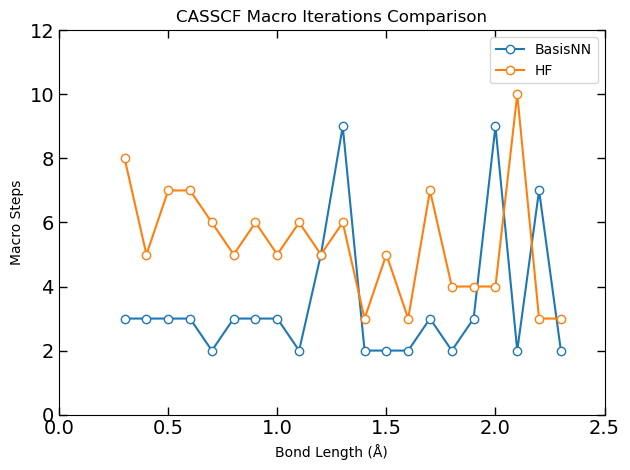

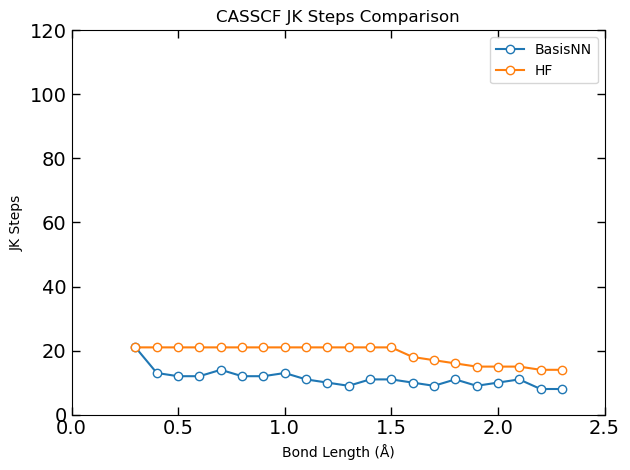

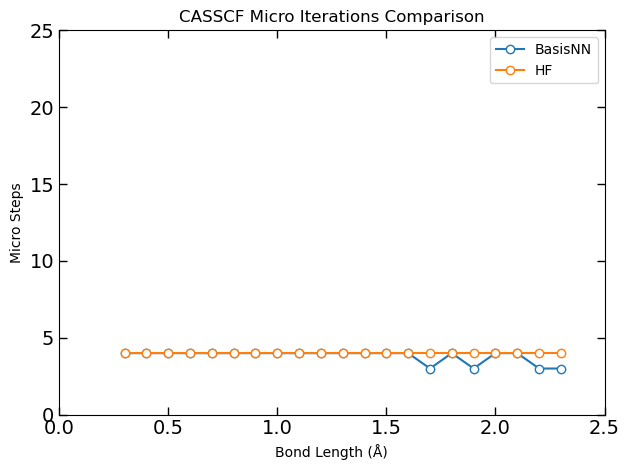

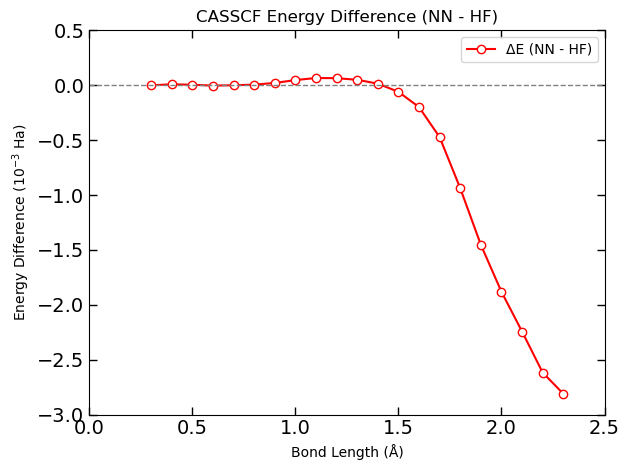

In [51]:
import numpy as np
import re
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

num_chains = 25  # Number of chains
chain_length = 4  # Number of H atoms per chain
bond_length_interval = 0.1
lengths = [bond_length_interval * point for point in range(3, num_chains + 1)]

# Regex patterns
pattern_steps = re.compile(r'CASSCF converged in\s+(\d+)\s+macro\s+\(\s*(\d+)\s+JK\s+(\d+)\s+micro')
pattern_energy = re.compile(r'CASSCF energy\s*=\s*([-+]?\d*\.\d+(?:[eE][-+]?\d+)?)')

# Get and sort log files
log_files = sorted(glob.glob("cas_init_result/log_*.txt"), key=lambda x: int(re.search(r'\d+', x).group()))

# Prepare lists
nn_macro, nn_jk, nn_micro = [], [], []
hf_macro, hf_jk, hf_micro = [], [], []
nn_energy, hf_energy = [], []
indices = []

# Extract data from each log
for log_file in log_files:
    with open(log_file, "r") as f:
        lines = f.readlines()

    # Extract steps
    matches_steps = [pattern_steps.search(line) for line in lines if "CASSCF converged" in line]
    matches_steps = [m for m in matches_steps if m]

    # Extract energies
    matches_energy = [pattern_energy.search(line) for line in lines if "CASSCF energy" in line]
    matches_energy = [m for m in matches_energy if m]

    if len(matches_steps) >= 2 and len(matches_energy) >= 2:
        # Steps
        nn_data = tuple(map(int, matches_steps[0].groups()))
        hf_data = tuple(map(int, matches_steps[1].groups()))
        nn_macro.append(nn_data[0])
        nn_jk.append(nn_data[1])
        nn_micro.append(nn_data[2])
        hf_macro.append(hf_data[0])
        hf_jk.append(hf_data[1])
        hf_micro.append(hf_data[2])

        # Energies
        nn_energy.append(float(matches_energy[0].group(1)))
        hf_energy.append(float(matches_energy[1].group(1)))

        indices.append(int(re.search(r'\d+', log_file).group()))

# Plot step comparisons
fig_titles = ['Macro Iterations', 'JK Steps', 'Micro Iterations']
nn_data_all = [nn_macro, nn_jk, nn_micro]
hf_data_all = [hf_macro, hf_jk, hf_micro]
ylabels = ['Macro Steps', 'JK Steps', 'Micro Steps']
y2_l = [12, 120, 25]

for i in range(3):
    plt.figure()
    plt.plot(lengths[:-2], nn_data_all[i][:-2], label='BasisNN', marker='o', markerfacecolor='white')
    plt.plot(lengths[:-2], hf_data_all[i][:-2], label='HF', marker='o', markerfacecolor='white')
    plt.xlabel('Bond Length (Å)')
    plt.ylabel(ylabels[i])
    plt.title(f'CASSCF {fig_titles[i]} Comparison')
    plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
    plt.xlim(0, 2.5)
    plt.ylim(0, y2_l[i])
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'figs/casscf_{fig_titles[i].lower().replace(" ", "_")}.pdf', metadata={"TextAsShapes": False})

# Plot energy difference ΔE = NN - HF
energy_diff = np.array([nn - hf for nn, hf in zip(nn_energy, hf_energy)])*1e3
print('E diff',energy_diff)

plt.figure()
plt.plot(lengths[:-2], energy_diff[:-2], label='ΔE (NN - HF)', marker='o', markerfacecolor='white', color='red')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy Difference ($10^{-3}$ Ha)')
plt.title('CASSCF Energy Difference (NN - HF)')
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
plt.xlim(0, 2.5)
plt.ylim(-3,0.5)
plt.legend()
plt.tight_layout()
#plt.savefig('figs/casscf_energy_difference.pdf', metadata={"TextAsShapes": False})


Parsed series lengths: {'NN': 3, 'HF': 7}
NN macros: [0, 1, 2]
HF macros: [0, 1, 2, 3, 4, 5, 6]


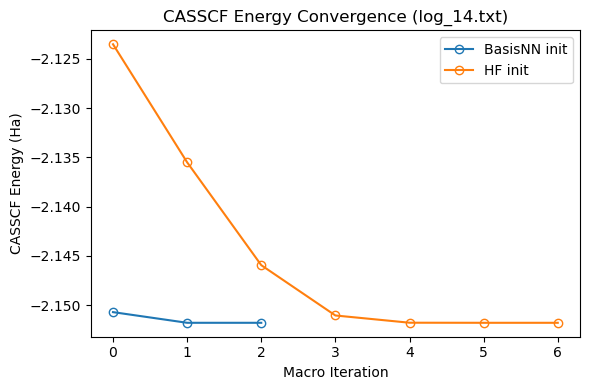

In [52]:
import re
import matplotlib.pyplot as plt

log_file = "cas_init_result/log_4.txt"
with open(log_file, "r") as f:
    text = f.read()

# Split NN vs HF blocks
mark = re.compile(r"Running CASSCF with\s+(NN|HF)\s+initial guess", re.I)
starts = list(mark.finditer(text))
blocks = []
for i, m in enumerate(starts):
    a = m.end()
    b = starts[i+1].start() if i+1 < len(starts) else len(text)
    blocks.append((m.group(1).upper(), text[a:b]))

NUM = r"[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?"
re_casci = re.compile(rf"CASCI\s+(?:energy|E)\s*=\s*({NUM})", re.I)
re_casscf_e = re.compile(rf"CASSCF\s+(?:E|energy)\s*=\s*({NUM})", re.I)
re_macro_idx = re.compile(r"macro\s*iter\s*(\d+)", re.I)
re_macro_pair = re.compile(rf"macro\s*iter\s*(\d+).*?CASSCF\s+(?:E|energy)\s*=\s*({NUM})", re.I)
re_converged = re.compile(r"CASSCF\s+converged\s+in\s+(\d+)\s+macro", re.I)

def series_from_block(txt, join_window=8, densify=True):
    mconv = re_converged.search(txt)
    if mconv:
        max_macro = int(mconv.group(1))
        txt_core = txt[:mconv.start()]
    else:
        max_macro = None
        txt_core = txt

    m0 = re_casci.search(txt_core) or re_casci.search(txt)
    if m0:
        E0 = float(m0.group(1))
    else:
        mf = re_casscf_e.search(txt_core) or re_casscf_e.search(txt)
        if not mf:
            return [], []
        E0 = float(mf.group(1))

    macro_to_E = {}

    for k, e in re_macro_pair.findall(txt_core):
        macro_to_E[int(k)] = float(e)    # keep last seen per k

    if not macro_to_E:
        lines = txt_core.splitlines()
        n = len(lines)
        for i, line in enumerate(lines):
            mi = re_macro_idx.search(line)
            if not mi:
                continue
            k = int(mi.group(1))
            E = None
            for j in range(i, min(i + join_window, n)):
                me = re_casscf_e.search(lines[j])
                if me:
                    E = float(me.group(1))
                    break
            if E is not None:
                macro_to_E[k] = E

    if max_macro is not None:
        macro_to_E = {k: v for k, v in macro_to_E.items() if k <= max_macro}

    if not macro_to_E:
        return [0], [E0]

    ks = sorted(macro_to_E)
    xs = [0] + ks
    ys = [E0] + [macro_to_E[k] for k in ks]

    if densify and max_macro is not None:
        full_x = list(range(0, max_macro + 1))
        y_map = dict(zip(xs, ys))
        full_y, last = [], None
        for k in full_x:
            last = y_map.get(k, last if last is not None else E0)
            full_y.append(last)
        return full_x, full_y

    return xs, ys

# Build NN/HF series
series = {label: series_from_block(chunk) for label, chunk in blocks}
x_nn, y_nn = series.get("NN", ([], []))
x_hf, y_hf = series.get("HF", ([], []))

print("Parsed series lengths:", {"NN": len(y_nn), "HF": len(y_hf)})
print("NN macros:", x_nn)
print("HF macros:", x_hf)

if not y_nn or not y_hf:
    raise RuntimeError("Missing energies to plot — check the printed series above.")

# Plot against macro iteration numbers
plt.figure(figsize=(6, 4))
plt.plot(x_nn, y_nn, label="BasisNN init", marker='o', fillstyle='none')
plt.plot(x_hf, y_hf, label="HF init",      marker='o', fillstyle='none')
plt.xlabel("Macro Iteration")
plt.ylabel("CASSCF Energy (Ha)")
plt.title("CASSCF Energy Convergence (log_14.txt)")
plt.legend()
plt.ticklabel_format(axis='y', style='plain', useOffset=False)
plt.tight_layout()
plt.show()
